# Facial Expression Recognition

In this notebook I will import a facial expression dataset and preprocess it so that it can be input into models

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

First i'll import the data

In [2]:
dataset = pd.read_csv('data\\fer2013.csv')

In [3]:
dataset.head()

,Label,pixels,Usage
0,0.0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0.0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2.0,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4.0,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6.0,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
dataset.tail() # some empty spots in the bottom

,Label,pixels,Usage
35885,3.0,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2.0,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest
35887,NaN,NaN,NaN
35888,NaN,NaN,NaN
35889,NaN,NaN,NaN


There are a couple of null values at the end. I'll drop those. Also, the pixels column is nested. It needs to be split into unique columns. The dataset is 48 by 48 = 2304 pixels, which will be stored flat in a data frame. 

In [5]:
dataset.dropna(inplace = True)

In [6]:
dataset[list(range(2304))] = pd.DataFrame(dataset.pixels.str.split().values.tolist()) # unnest the pixels column

We no longer need the nested pixels column.

In [7]:
dataset.drop(columns='pixels',axis = 0, inplace=True )

Finally, we will want to normalize these values so they are between 0-1. We could also subtract the mean and divide by the standard deviation as is typical when scaling data, but image data is more naturally interpretable on the 0-1 scale and this just requires dividing by the max pixel value, 255. To speed up data processing to floats instead of strings I first convert to a numpy array since it is faster.

In [8]:
pixel_data = dataset.iloc[:,list(range(2,2306))].as_matrix() # conver to numpy

In [9]:
pixel_data = pixel_data.astype(np.float32)/255 #divide  by 255

In [10]:
dataset = pd.concat([dataset.iloc[:,:2], pd.DataFrame(pixel_data)],axis = 1) #rebuild dataframe using first two columns + the numpy array

In [11]:
dataset.dtypes.head()

Label    float64
Usage     object
0        float32
1        float32
2        float32
dtype: object

Next we can split into the training and test set using the presupplied labels

In [12]:
training_ind = dataset.Usage == 'Training'
test_ind = ~training_ind

In [13]:
Xtrain, ytrain = pixel_data[training_ind.values, :], np.array(dataset.Label[training_ind].astype(int))
Xtest, ytest = pixel_data[test_ind.values, :], np.array(dataset.Label[test_ind].astype(int))

In [14]:
class_counts = np.bincount(ytrain)
print(class_counts)# major class imbalance

[3995  436 4097 7215 4830 3171 4965]


We can see there is major class imbalance. I'll just add in some repeated versions of class 1 so that this imbalance isn't so bad.

In [15]:
class1 = Xtrain[ytrain == 1,:]

In [16]:
class1 = np.repeat(class1, repeats = 7, axis = 0)

In [17]:
class1.shape

(3052, 2304)

Next we can rebuild the training dataset and save the traning and test sets using pickle for easy importing into other notebooks

In [18]:
Xtrain, ytrain = np.concatenate([Xtrain, class1],axis = 0), np.hstack([ytrain, np.repeat(1,3052)])

In [19]:
class_counts = np.bincount(ytrain)
print(class_counts)# no more major class imbalance

[3995 3488 4097 7215 4830 3171 4965]


In [20]:
import pickle
pickle.dump(np.concatenate((Xtrain,ytrain.reshape(-1,1)), axis = 1), open( "data\TrainData.p", "wb" ))
pickle.dump(np.concatenate((Xtest,ytest.reshape(-1,1)), axis = 1), open( "data\TestData.p", "wb" ) )

Finally, let's see what we are dealing with. What do these pictures look like? We just have to recast the pixels to 48 by 48  so it looks like an actual image

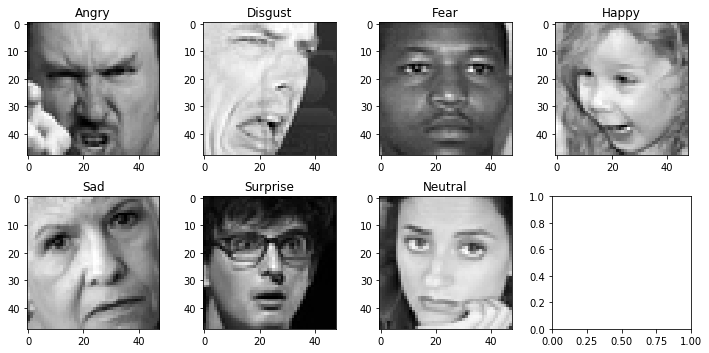

In [21]:
fig, ax = plt.subplots(2,4, figsize = (10,5))
ax = ax.flatten()
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
for i in range(7):
    ind = np.random.choice(range(1000))
    tmp = Xtrain[ytrain == i,:]
    pic = tmp[ind,:].reshape(48,48)
    ax[i].imshow(pic, cmap = 'gray')
    ax[i].set_title(emotions[i])
plt.tight_layout()

This is obviously pretty complex information. We'll see if we can develop some models to learn these features in the subsequent notebooks.